<h2>1 - Data Preperation<h2>

<h3>1.1 - Importing Data/Libraries</h3>

In [139]:
import pandas as pd
import numpy as np
from Analyzer import Analyzer
from LSTM import LSTM
from Markov import Markov
from matplotlib.pyplot import figure
import matplotlib.pyplot as plt

In [140]:
df1 = pd.read_json('./Datasets/generated_data_Economics.json')
df2 = pd.read_csv('./Datasets/VOO.csv')

In [141]:
#Subreddit Data
df1.head()

,Economics
2022-09-01 12:40:00,"{'polarity': 0.4, 'subjectivity': 0.7000000000..."
2022-09-01 12:42:00,"{'polarity': 0.5, 'subjectivity': 0.6000000000..."
2022-09-01 12:43:00,"{'polarity': 0.1, 'subjectivity': 0.4, 'compou..."
2022-09-01 12:44:00,"{'polarity': 0.5, 'subjectivity': 0.925, 'comp..."
2022-09-01 12:47:00,"{'polarity': 0.1071428571, 'subjectivity': 0.3..."


In [142]:
#Stock Data
df2.head()

,Unnamed: 0,Adj Close
0,2022-08-29 09:30:00-04:00,369.648010
1,2022-08-29 09:31:00-04:00,369.799988
2,2022-08-29 09:33:00-04:00,370.220001
3,2022-08-29 09:34:00-04:00,370.549988
4,2022-08-29 09:35:00-04:00,370.299988


<h3>1.2 - Preparing The Subreddit Sentiment Data </h3>

In [143]:
#Bring out date/time data from index
df1.reset_index(inplace=True)
df1['index'] = pd.to_datetime(df1['index'])
df1['date'] = df1['index'].dt.date

#Group times and their corresponding sentiment data into a list by day
df1['time'] = df1['index']
df1 = df1.groupby('date').agg(list)
df1.reset_index(inplace=True)

#Create final dataframe
df1 = df1[['date', 'time', 'Economics']]
df1.head()

,date,time,Economics
0,2022-09-01,"[2022-09-01 12:40:00, 2022-09-01 12:42:00, 202...","[{'polarity': 0.4, 'subjectivity': 0.700000000..."
1,2022-09-02,"[2022-09-02 09:41:00, 2022-09-02 09:42:00, 202...","[{'polarity': 0.0, 'subjectivity': 0.0, 'compo..."
2,2022-09-03,"[2022-09-03 09:36:00, 2022-09-03 09:38:00, 202...","[{'polarity': 0.1, 'subjectivity': 1.3, 'compo..."
3,2022-09-04,"[2022-09-04 09:42:00, 2022-09-04 09:43:00, 202...","[{'polarity': 0.0, 'subjectivity': 0.0, 'compo..."
4,2022-09-05,"[2022-09-05 12:56:00, 2022-09-05 13:00:00, 202...","[{'polarity': 0.0, 'subjectivity': 0.0, 'compo..."


<h3>1.3 - Preparing The Stock Price Data<h3>

In [144]:
#Bring out date/time data from index
df2['date_time'] = pd.to_datetime(df2['Unnamed: 0'])
df2['date'] = df2['date_time'].dt.date
df2['time'] = df2['date_time'].dt.tz_localize(None)

#Group times and their corresponding price data into a list by day
df2 = df2.groupby('date').agg(list)
df2.reset_index(inplace=True)

#Create Final Dataframe
df2.rename(columns={'Adj Close': 'price'}, inplace=True)
df2 = df2[['price', 'date', 'time']]
df2.head(5)


,price,date,time
0,"[369.6480102539063, 369.7999877929688, 370.220...",2022-08-29,"[2022-08-29 09:30:00, 2022-08-29 09:31:00, 202..."
1,"[371.2200012207031, 370.760009765625, 371.0400...",2022-08-30,"[2022-08-30 09:30:00, 2022-08-30 09:31:00, 202..."
2,"[367.0400085449219, 367.0700073242188, 366.660...",2022-08-31,"[2022-08-31 09:30:00, 2022-08-31 09:31:00, 202..."
3,"[361.5299987792969, 360.8349914550781, 360.959...",2022-09-01,"[2022-09-01 09:30:00, 2022-09-01 09:31:00, 202..."
4,"[367.3999938964844, 366.8800048828125, 366.709...",2022-09-02,"[2022-09-02 09:30:00, 2022-09-02 09:31:00, 202..."


<h3>1.4 - Merging The Sentiment Data And Stock Price Data<h3>

In [145]:
#merge stock/sentiment data according to the date value
df = pd.merge(df1, df2, how='outer', on='date')
df['date'] =  pd.to_datetime(df['date'])
df.rename(columns={'time_x': 'sentiment_time', 'time_y':'stock_time'}, inplace=True)

#get rid of rows that have no sentiment data
df.dropna(inplace=True)
df['na'] = np.nan
df.head()

,date,sentiment_time,Economics,price,stock_time,na
0,2022-09-01,"[2022-09-01 12:40:00, 2022-09-01 12:42:00, 202...","[{'polarity': 0.4, 'subjectivity': 0.700000000...","[361.5299987792969, 360.8349914550781, 360.959...","[2022-09-01 09:30:00, 2022-09-01 09:31:00, 202...",NaN
1,2022-09-02,"[2022-09-02 09:41:00, 2022-09-02 09:42:00, 202...","[{'polarity': 0.0, 'subjectivity': 0.0, 'compo...","[367.3999938964844, 366.8800048828125, 366.709...","[2022-09-02 09:30:00, 2022-09-02 09:31:00, 202...",NaN
5,2022-09-06,"[2022-09-06 12:30:00, 2022-09-06 12:46:00, 202...","[{'polarity': 0.8, 'subjectivity': 1.0, 'compo...","[362.0299987792969, 361.6700134277344, 361.609...","[2022-09-06 09:30:00, 2022-09-06 09:31:00, 202...",NaN
6,2022-09-07,"[2022-09-07 12:40:00, 2022-09-07 12:46:00, 202...","[{'polarity': 0.1, 'subjectivity': 0.700000000...","[358.7699890136719, 359.3039855957031, 359.040...","[2022-09-07 09:30:00, 2022-09-07 09:31:00, 202...",NaN
7,2022-09-08,"[2022-09-08 13:00:00, 2022-09-08 13:01:00, 202...","[{'polarity': -0.2, 'subjectivity': 0.0, 'comp...","[362.5960083007813, 362.9599914550781, 362.929...","[2022-09-08 09:30:00, 2022-09-08 09:31:00, 202...",NaN


<h3>1.5 - Determining Percent Change In Price<h3>

In [146]:
def generate_price_dif(row):
    prices = np.asarray(row['price'])
    price_shift = np.asarray([row['price'][-1]] + row['price'][:-1])
    delta_price = prices - price_shift
    return delta_price

#Create the price difference/percent change columns using the above function
df['price_diff']  = df.apply(lambda row: generate_price_dif(row), axis=1)
df['percent_change'] = df.apply(lambda row: (row['price_diff']/np.asarray(row['price'])) * 100, axis= 1)

df.head()

,date,sentiment_time,Economics,price,stock_time,na,price_diff,percent_change
0,2022-09-01,"[2022-09-01 12:40:00, 2022-09-01 12:42:00, 202...","[{'polarity': 0.4, 'subjectivity': 0.700000000...","[361.5299987792969, 360.8349914550781, 360.959...","[2022-09-01 09:30:00, 2022-09-01 09:31:00, 202...",NaN,"[-2.850006103515625, -0.69500732421875, 0.125,...","[-0.7883180132046159, -0.19261084447938703, 0...."
1,2022-09-02,"[2022-09-02 09:41:00, 2022-09-02 09:42:00, 202...","[{'polarity': 0.0, 'subjectivity': 0.0, 'compo...","[367.3999938964844, 366.8800048828125, 366.709...","[2022-09-02 09:30:00, 2022-09-02 09:31:00, 202...",NaN,"[6.850006103515568, -0.519989013671875, -0.170...","[1.8644546046033876, -0.1417327209854263, -0.0..."
5,2022-09-06,"[2022-09-06 12:30:00, 2022-09-06 12:46:00, 202...","[{'polarity': 0.8, 'subjectivity': 1.0, 'compo...","[362.0299987792969, 361.6700134277344, 361.609...","[2022-09-06 09:30:00, 2022-09-06 09:31:00, 202...",NaN,"[2.839996337890625, -0.3599853515625, -0.06002...","[0.7844643668940712, -0.09953419918636108, -0...."
6,2022-09-07,"[2022-09-07 12:40:00, 2022-09-07 12:46:00, 202...","[{'polarity': 0.1, 'subjectivity': 0.700000000...","[358.7699890136719, 359.3039855957031, 359.040...","[2022-09-07 09:30:00, 2022-09-07 09:31:00, 202...",NaN,"[-6.920013427734432, 0.53399658203125, -0.2639...","[-1.928816132798311, 0.14861972130532247, -0.0..."
7,2022-09-08,"[2022-09-08 13:00:00, 2022-09-08 13:01:00, 202...","[{'polarity': -0.2, 'subjectivity': 0.0, 'comp...","[362.5960083007813, 362.9599914550781, 362.929...","[2022-09-08 09:30:00, 2022-09-08 09:31:00, 202...",NaN,"[-5.4739990234375, 0.36398315429681816, -0.029...","[-1.5096688595911674, 0.10028189411114934, -0...."


<h2>2 - Visualizing Trends In News Sentiment and Stock Prices</h2>

<h3>2.1 - Plotting Sentiment Versus Price</h3>

In [147]:
analyzer = Analyzer(['Economics'], df)

In [148]:
analyzer.df_dict['Economics'] = analyzer.df_dict['Economics'].reset_index()

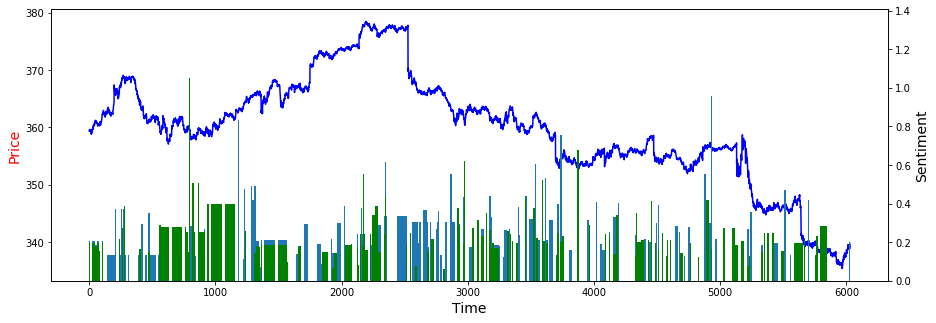

In [149]:
analyzer.plot_subreddits_day(['Economics'])

<h2>3 - Markov Chains<h2>

In [150]:
analyzer.markov_chain_data()

<h3>3.1 - Plotting Hist</h3>

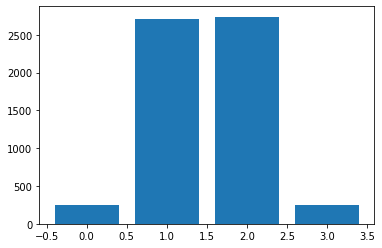

In [151]:
analyzer.plot_markov_hist()

<h3>3.2 - Nth Degree Markov Chains<h3>

In [152]:
bins = analyzer.complete_markov['Economics']
train = list(bins[:int(len(bins) * .7)])
test = list(bins[int(len(bins) * .7):])
markov = Markov()

<h3>3.3 - Optimizing Nth Degree Markov Chains<h3>

9
0.4215042253521128


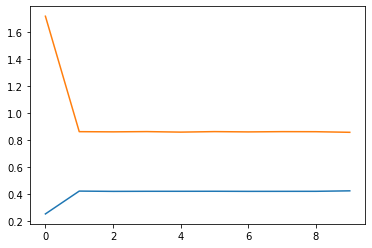

In [153]:
markov.optimal_degree(train, test, 100, range(10))

<h2>4 - Univariate LSTM Network<h2>

<h3>4.1 - Processing And Splititng Data</h3>

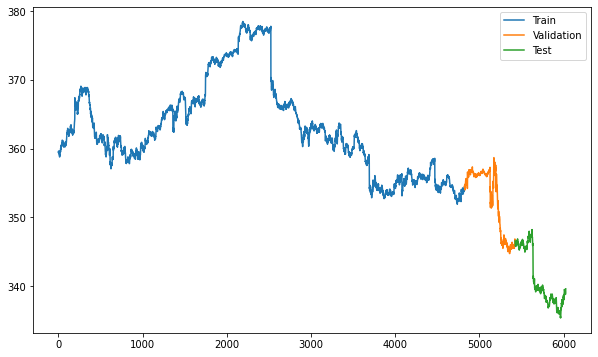

In [154]:
uni_lstm = LSTM(analyzer.df_dict['Economics'], ['price'])
uni_lstm.divide_data()

<h3>4.2 - Fitting The Model</h3>

In [155]:
uni_lstm.run()

Epoch 1/70
151/151 [==============================] - 2s 4ms/step - loss: 118492.6719 - mean_absolute_error: 343.5053 - val_loss: 75775.5234 - val_mean_absolute_error: 275.2350
Epoch 2/70
151/151 [==============================] - 0s 2ms/step - loss: 24088.6523 - mean_absolute_error: 124.5344 - val_loss: 97.2286 - val_mean_absolute_error: 8.7195
Epoch 3/70
151/151 [==============================] - 0s 2ms/step - loss: 46.0467 - mean_absolute_error: 5.4368 - val_loss: 126.9126 - val_mean_absolute_error: 10.2817
Epoch 4/70
151/151 [==============================] - 0s 2ms/step - loss: 45.8880 - mean_absolute_error: 5.4197 - val_loss: 128.8999 - val_mean_absolute_error: 10.3779
Epoch 5/70
151/151 [==============================] - 0s 2ms/step - loss: 45.9172 - mean_absolute_error: 5.4117 - val_loss: 130.2292 - val_mean_absolute_error: 10.4418
Epoch 6/70
151/151 [==============================] - 0s 2ms/step - loss: 45.9834 - mean_absolute_error: 5.4322 - val_loss: 120.9887 - val_mean_abso

<h3>4.3 - Plotting True And Predicted Values</h3>

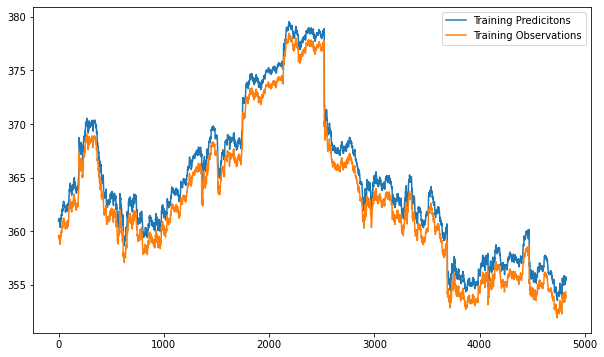

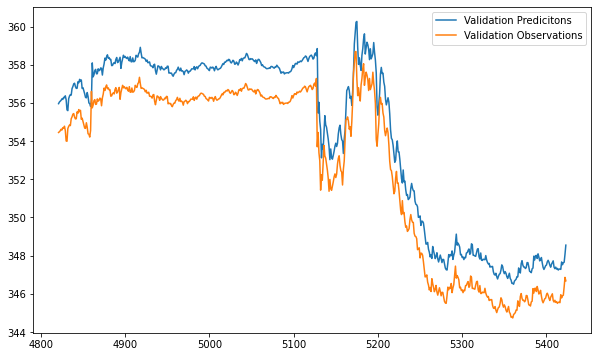

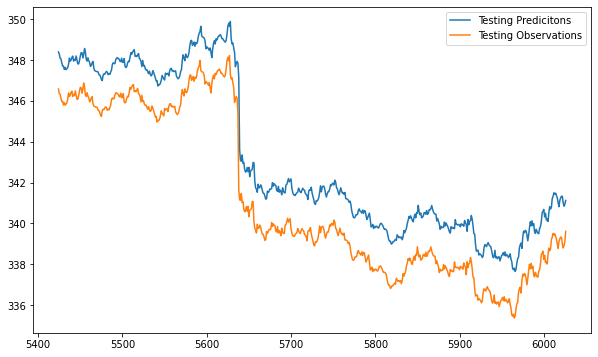

In [156]:
uni_lstm.plot([
    (uni_lstm.steps_train, uni_lstm.X_train, uni_lstm.y_train, 'Training'),
    (uni_lstm.steps_val, uni_lstm.X_val, uni_lstm.y_val, 'Validation'),
    (uni_lstm.steps_test, uni_lstm.X_test, uni_lstm.y_test, 'Testing'),
])


<h3>4.4 - Comparing n Values</h3>

In [157]:
analyzer.df_dict['Economics'] = analyzer.df_dict['Economics'].drop(columns='time')

In [ ]:
analyzer.df_dict['Economics'] = analyzer.df_dict['Economics'].drop(columns='markov_bins')
analyzer.df_dict['Economics']

In [161]:
from copy import deepcopy
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers
from sklearn.preprocessing import MinMaxScaler
from matplotlib.pyplot import figure
import datetime
import numpy as np
import matplotlib.pyplot as plt

class LSTM:
    def __init__(self, input_df, cols=None, n=3):
        self.model = None
        self.input_df = input_df
        if cols:
            self.cols = cols
        else:
            self.cols = input_df.columns.to_list()
        self.n = n

    def window_data(self):
        self.steps, self.X, self.y = self.windowed_df_to_date_X_y(self.input_df, self.cols, self.n)


    def str_to_datetime(self, s: str):
        split = s.split('-')
        year, month, day = int(split[0]), int(split[1]), int(split[2])
        return datetime.datetime(year=year, month=month, day=day)


    def windowed_df_to_date_X_y(self, windowed_dataframe, cols, n=3):
        scaler = MinMaxScaler()
        df_as_np = windowed_dataframe[cols].to_numpy()
        X = []
        y = []
        
        #get dates -> first column of df
        index = np.asarray([i for i in range(len(df_as_np[:, 0])-n)])

        for i in range(len(df_as_np) - n):
            row = [r for r in df_as_np[i:i+n]]
            X.append(row)
            label = df_as_np[i+n][0]
            y.append(label)


        return index, np.array(X), np.array(y)

    def divide_data(self, plots = True):
        self.window_data()
        q_80 = int(len(self.steps) * .8)
        q_90 = int(len(self.steps) * .9)

        self.steps_train, self.X_train, self.y_train = self.steps[:q_80], self.X[:q_80], self.y[:q_80]
        self.steps_val, self.X_val, self.y_val = self.steps[q_80:q_90], self.X[q_80:q_90], self.y[q_80:q_90]
        self.steps_test, self.X_test, self.y_test = self.steps[q_90:], self.X[q_90:], self.y[q_90:]

        #plot the data to visualize the splits
        if plots:
            figure(figsize=(10, 6))
            plt.plot(self.steps_train, self.y_train)
            plt.plot(self.steps_val, self.y_val)
            plt.plot(self.steps_test, self.y_test)
            plt.legend(['Train', 'Validation', 'Test'])

    def generate_model(self):
        self.model = Sequential([
        layers.Input((self.n, len(self.cols))), # 3 because we look 3 days in the past and 1 because there is only one variable
        layers.LSTM(64),
        layers.Dense(32, activation = 'relu'),
        layers.Dense(32, activation = 'relu'),
        layers.Dense(1) # only want one output -> predicted cost

        ])

        self.model.compile(
            loss='mse', optimizer=Adam(learning_rate=0.001),
            metrics = ['mean_absolute_error']
        )

    def run(self):
        self.generate_model()
        self.hist = self.model.fit(self.X_train, self.y_train, validation_data=(self.X_val, self.y_val), epochs = 70)

    def predict(self, input):
        return self.model.predict(input).flatten()

    def plot(self, inputs):
        for input in inputs:
            steps, x_vals, y_vals, name = input
            predictions = self.predict(x_vals).flatten()
            figure(figsize=(10,6))
            plt.plot(steps, predictions)
            plt.plot(steps, y_vals)
            plt.legend([f'{name} Predicitons', f'{name} Observations'])

    def recursive_prediction(self):
        initial_slice = deepcopy(self.X_train)[0].reshape(1,self.n,len(self.cols))
        predictions = []

        for i in range(len(self.X_test)):
            prediction = self.predict(initial_slice)
            predictions.append(prediction)
            initial_slice = initial_slice[0][1:]
            new_slice = initial_slice[-1]
            new_slice[0] = prediction
            new_slice = new_slice.reshape(1, new_slice.shape[0])
            initial_slice = np.append(initial_slice, new_slice, axis = 0).reshape(1,self.n,len(self.cols))
            

        return predictions

       
        

In [162]:
def run_comparisons(start_val, end_val):
    errors = []
    models = []
    for i in range(start_val, end_val):
        lstm = LSTM(analyzer.df_dict['Economics'], n=i)
        lstm.divide_data(plots=False)
        lstm.run()
        errors.append(lstm.hist.history['mean_absolute_error'][-1])
        models.append(lstm)

    return errors, models

In [163]:
error, models = run_comparisons(3,10)

Epoch 1/70
151/151 [==============================] - 2s 4ms/step - loss: nan - mean_absolute_error: nan - val_loss: nan - val_mean_absolute_error: nan
Epoch 2/70
151/151 [==============================] - 0s 2ms/step - loss: nan - mean_absolute_error: nan - val_loss: nan - val_mean_absolute_error: nan
Epoch 3/70
151/151 [==============================] - 0s 2ms/step - loss: nan - mean_absolute_error: nan - val_loss: nan - val_mean_absolute_error: nan
Epoch 4/70
151/151 [==============================] - 0s 2ms/step - loss: nan - mean_absolute_error: nan - val_loss: nan - val_mean_absolute_error: nan
Epoch 5/70
151/151 [==============================] - 0s 2ms/step - loss: nan - mean_absolute_error: nan - val_loss: nan - val_mean_absolute_error: nan
Epoch 6/70
151/151 [==============================] - 0s 2ms/step - loss: nan - mean_absolute_error: nan - val_loss: nan - val_mean_absolute_error: nan
Epoch 7/70
151/151 [==============================] - 0s 2ms/step - loss: nan - mean_abs

KeyboardInterrupt: 

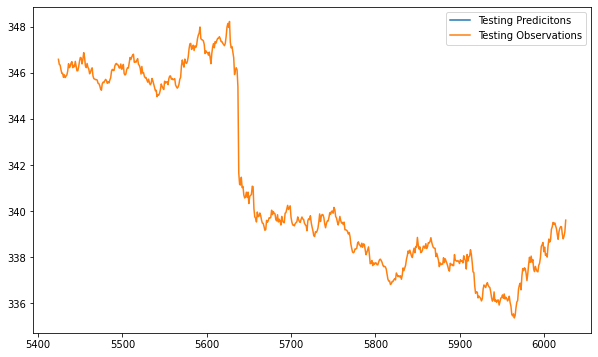

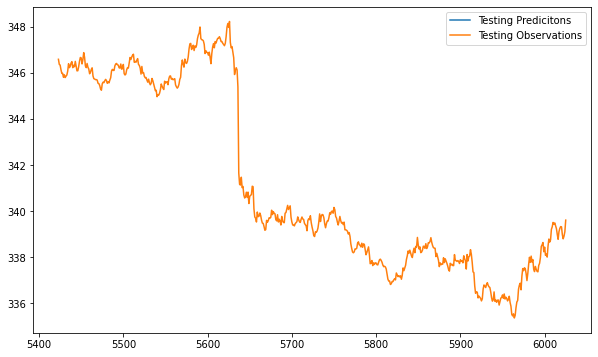

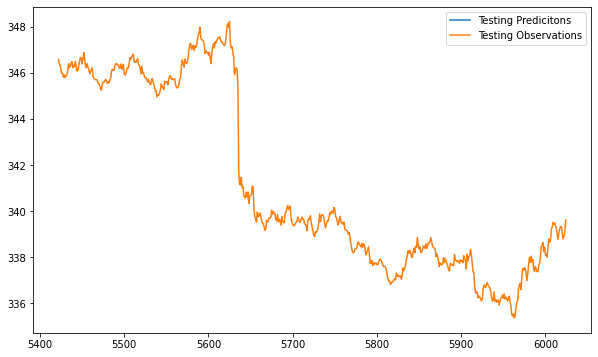

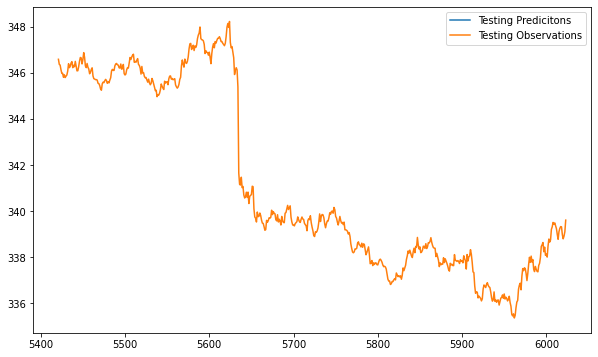

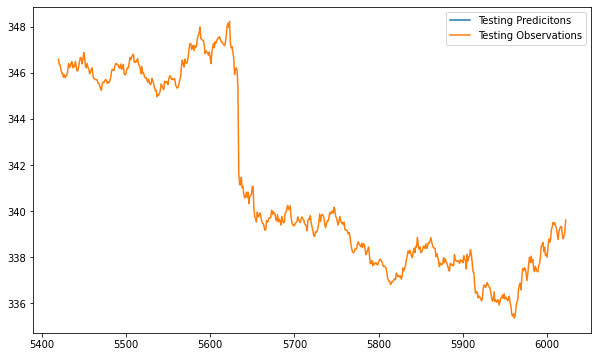

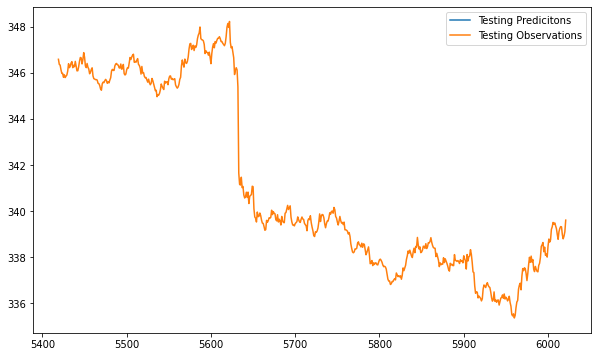

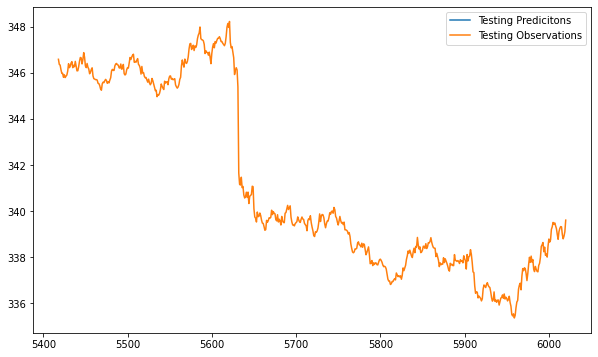

In [ ]:
for model in models:
    model.plot([(model.steps_test, model.X_test, model.y_test, 'Testing')])

<h2>5 - Multivariate LSTM Network Using News Sentiments</h2>

<h3>5.1 - Processing And Splitting Data </h3>

,price,percent_change,polarity,subjectivity,compound,neg,neu,pos
time,,,,,,,,
2022-09-01 12:40:00,359.350006,-0.027830,0.4,0.700,-0.0743,0.478,1.089,0.432
2022-09-01 12:41:00,359.459991,0.030597,0.4,0.700,-0.0743,0.478,1.089,0.432
2022-09-01 12:42:00,359.450012,-0.002776,0.5,0.600,0.1280,0.248,0.470,0.282
2022-09-01 12:43:00,359.468994,0.005281,0.1,0.400,-0.0772,0.204,0.602,0.194
2022-09-01 12:44:00,359.619995,0.041989,0.5,0.925,-0.3124,0.567,1.037,0.395
...,...,...,...,...,...,...,...,...
2022-09-23 15:55:00,338.980011,-0.100300,0.0,0.000,-0.2500,0.200,0.800,0.000
2022-09-23 15:56:00,338.799988,-0.053136,0.0,0.000,-0.2500,0.200,0.800,0.000
2022-09-23 15:57:00,338.920013,0.035414,0.0,0.000,-0.2500,0.200,0.800,0.000


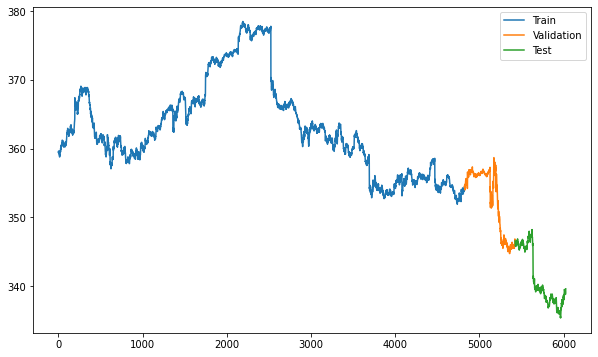

In [ ]:
multi_lstm = LSTM(analyzer.df_dict['Economics'])
multi_lstm.divide_data()

<h3>5.2 - Fitting The Model </h3>

In [ ]:
multi_lstm.run()

Epoch 1/70
151/151 [==============================] - 2s 4ms/step - loss: 120803.1250 - mean_absolute_error: 347.0612 - val_loss: 82703.4844 - val_mean_absolute_error: 287.5453
Epoch 2/70
151/151 [==============================] - 0s 2ms/step - loss: 29709.6465 - mean_absolute_error: 143.7850 - val_loss: 93.4233 - val_mean_absolute_error: 8.4984
Epoch 3/70
151/151 [==============================] - 0s 2ms/step - loss: 46.2794 - mean_absolute_error: 5.4854 - val_loss: 127.9068 - val_mean_absolute_error: 10.3299
Epoch 4/70
151/151 [==============================] - 0s 2ms/step - loss: 45.9131 - mean_absolute_error: 5.4166 - val_loss: 131.7745 - val_mean_absolute_error: 10.5155
Epoch 5/70
151/151 [==============================] - 0s 2ms/step - loss: 45.7781 - mean_absolute_error: 5.4149 - val_loss: 121.6272 - val_mean_absolute_error: 10.0442
Epoch 6/70
151/151 [==============================] - 0s 2ms/step - loss: 43.8210 - mean_absolute_error: 5.2506 - val_loss: 108.7224 - val_mean_abso

<h3>5.3 - Plotting True And Predicted Values </h3>

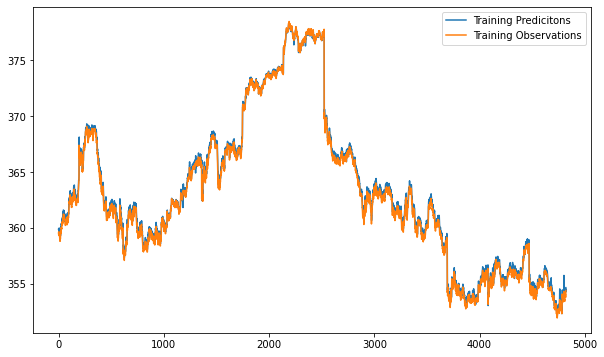

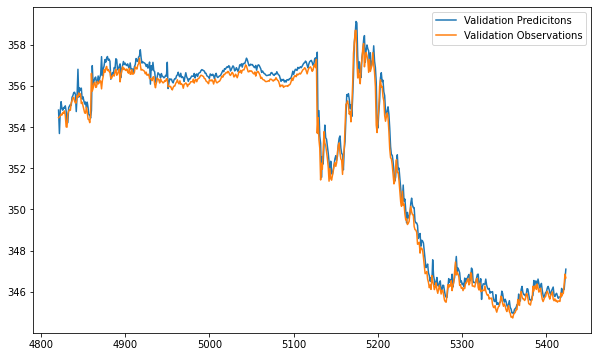

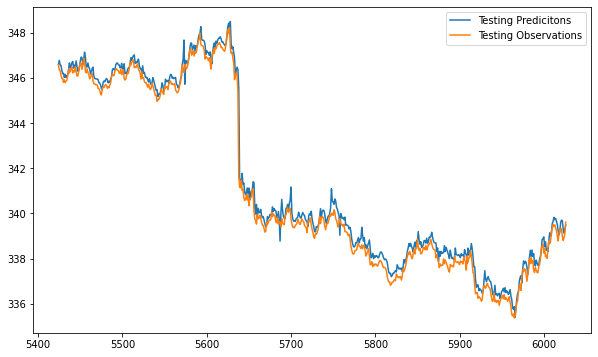

In [ ]:
multi_lstm.plot([
    (multi_lstm.steps_train, multi_lstm.X_train, multi_lstm.y_train, 'Training'),
    (multi_lstm.steps_val, multi_lstm.X_val, multi_lstm.y_val, 'Validation'),
    (multi_lstm.steps_test, multi_lstm.X_test, multi_lstm.y_test, 'Testing'),
])

<h3>5.4 - Prediction Of Future Values </h3>

In [ ]:
predictions = multi_lstm.recursive_prediction()

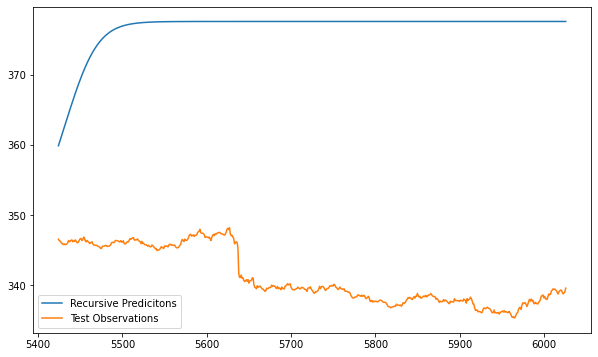

In [ ]:
figure(figsize=(10,6))
plt.plot(multi_lstm.steps_test, predictions)
plt.plot(multi_lstm.steps_test, multi_lstm.y_test)
plt.legend(['Recursive Predicitons', 'Test Observations'])